# Week 3: Histopathologic Cancer Detection with CNN

## Brief description of the problem and Data.

### Description 
The Histopathologic Cancer Detection competition focuses on detecting metastatic cancer in small tissue image patches derived from digital pathology scans. Each image is a 96x96 pixel RGB patch extracted from lymph node sections. The challenge is to develop a binary classification model that can accurately predict whether a patch contains cancerous cells or not. This work has real-world implications in assisting pathologists with faster and more accurate cancer diagnoses, ultimately improving treatment outcomes.

### Data Characteristics
#### Image Size:
96x96 pixels, RGB format (3 channels)

#### Training Samples:
~220,000 labeled images (positive = cancer, negative = no cancer)

#### Test Samples:
~57,000 unlabeled images for prediction

#### Labels:

1 → Metastatic cancer present

0 → No cancer

#### Data Format:

Images stored in train/ and test/ directories

Labels provided in a CSV: train_labels.csv (with id and label columns)

##### Kaggle Dataset:  https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview

In [31]:
import numpy as np # linear algebra
import pandas as pd
import os
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import keras
from keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
df = pd.read_csv('/Users/kashmiratare/Documents/Deep Learning/CNN_CancerDetection/Dataset/train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [19]:
print(df['label'].value_counts())
print(df.isnull().sum())

label
0    130908
1     89117
Name: count, dtype: int64
id       0
label    0
dtype: int64


In [27]:
# Paths to the data directories
train_dir = '/Users/kashmiratare/Documents/Deep Learning/CNN_CancerDetection/Dataset/train'
test_dir = '/Users/kashmiratare/Documents/Deep Learning/CNN_CancerDetection/Dataset/test'

# Load the labels
labels = pd.read_csv('/Users/kashmiratare/Documents/Deep Learning/CNN_CancerDetection/Dataset/train_labels.csv')

In [28]:
import pathlib

train_path = '/Users/kashmiratare/Documents/Deep Learning/CNN_CancerDetection/Dataset/train'
test_path = '/Users/kashmiratare/Documents/Deep Learning/CNN_CancerDetection/Dataset/test'
train_dir = pathlib.Path(train_path).with_suffix('')
test_dir = pathlib.Path(test_path).with_suffix('')

train_imgs = list(train_dir.glob('*.tif'))
test_imgs = list(test_dir.glob('*.tif'))

print(len(train_imgs))
print(len(test_imgs))

220025
57458


## Exploratory Data Analysis (EDA)

#### Data preview of sample images with Label 0 and Label 1

In [29]:
import os
# Get training and testing files
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

print('Training image files: ')
print(train_files[:10])
print('Testing image files: ')
print(test_files[:10])

Training image files: 
['f0c2a0b8ef3024f407fa97d852d49be0215cafe0.tif', '99ef485f205645918613cd04281098daa7c17819.tif', 'e2612e173abd0e8bb54a3c3db3f264b63d80bffb.tif', '6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0.tif', '9c043ab2adadfeb758c71d21432fccd3e43565c0.tif', '9cc775713dd09351172a350871a547346af08027.tif', '1996c210f020134e986823ca7d4df0a70a799c34.tif', '270d16e6b9d88f09f3cc2e538f23091b186a33e5.tif', '731fe361f4af33b5e4f11d74b2bc7508171904e6.tif', 'c7cf86c53ef00698e1e46f430e8527b534bd0368.tif']
Testing image files: 
['fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif', '1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif', '19709bec800f372d0b1d085da6933dd3ef108846.tif', '7a34fc34523063f13f0617f7518a0330f6187bd3.tif', '93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif', '761dde7de22cb39a0dd67ce472163d66e5ac1568.tif', '58055ce8819717a100b48d019e139be4fdf997c0.tif', '9735b584631f4b942b022d40aecdbe2aa8f6ae5e.tif', '860bbd33f8483a45858c4998021bc7434117deda.tif', '99050fbce64ae16e48e8a3b09d38f3b16df63fbe

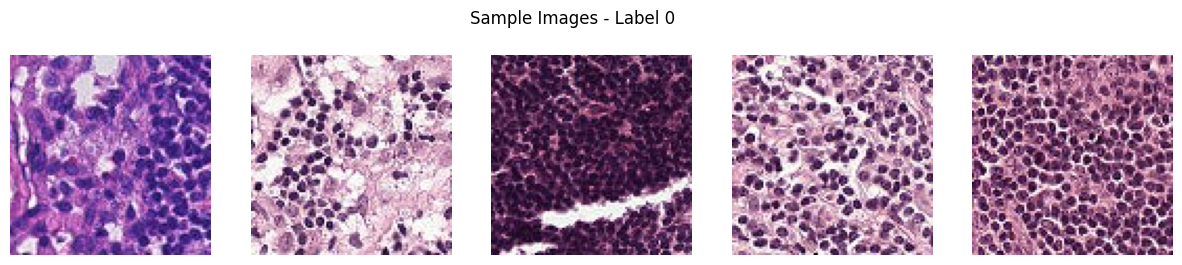

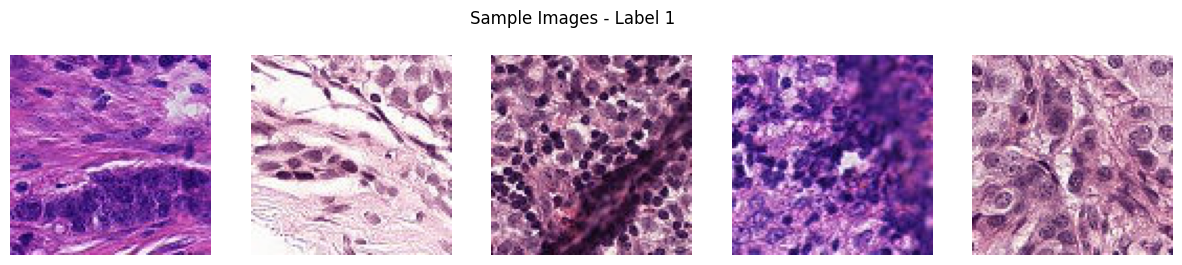

In [32]:
def plot_samples(label, num_samples=5):
    samples = labels[labels['label'] == label].sample(num_samples)
    plt.figure(figsize=(15, 3))
    for idx, img_name in enumerate(samples['id']):
        img_path = os.path.join(train_dir, img_name + '.tif')
        img = Image.open(img_path)
        plt.subplot(1, num_samples, idx+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Sample Images - Label {label}')
    plt.show()

plot_samples(label=0)
plot_samples(label=1)

In [33]:
# Missing values
labels.isnull().sum()

id       0
label    0
dtype: int64

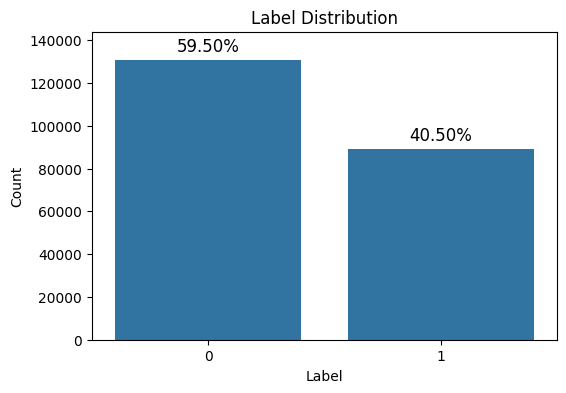

In [35]:
# Distribution
label_counts = df['label'].value_counts()
total = len(df)

# Plot
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x='label')

for p in ax.patches:
    count = p.get_height()
    percent = f'{100 * count / total:.2f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + total * 0.01, percent, ha='center', va='bottom', fontsize=12)

# Format
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.ylim(0, label_counts.max() * 1.1)
plt.show()

## Build CNN Model Architecture

We use a Convolutional Neural Network (CNN) to classify each image as tumor or not. CNNs are particularly suited for this task because they can automatically learn spatial patterns in images, such as abnormal cell structures typical of cancer.

#### Key components of the CNN model include:

##### Convolutional layers: to extract features like edges, textures, and shapes.

##### Pooling layers: to reduce dimensionality and retain essential information.

##### Fully connected layers: to classify based on the learned features.

##### Sigmoid output: for binary classification (tumor vs. normal).



In [36]:
# Convolution and Pooling layers
config = [Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
          MaxPooling2D(2,2),
          
          Conv2D(64, (3,3), activation='relu'),
          MaxPooling2D(2,2),
          
          Flatten(),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')]

model = Sequential(config)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# Compile
learning_rate = 0.001
opt = keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
from sklearn.model_selection import train_test_split

train_labels, val_labels = train_test_split(labels,
                                            test_size = 0.2,
                                            random_state = 0)

In [39]:
train_labels.head()


,id,label
205571,a42ed368dfea7e31fcde574fc9ab5ec921642cd4,1
18438,54946370aec5fe50c6c8595e880f58051445b007,1
47235,a1091dc4027ac7fb5d6fdd96c6b3d3571c6adbdf,1
42780,09afaac18518e435c68fc1b635690c79b52d1a0e,0
70202,8ab7670b07494ca3b51b570fc243467a7a45895c,1


In [40]:
# Convert labels to strings
train_labels['label'] = train_labels['label'].astype(str)
val_labels['label'] = val_labels['label'].astype(str)

# Create a new 'filename' column by adding '.tif' extension
train_labels['filename'] = train_labels['id'] + '.tif'
val_labels['filename'] = val_labels['id'] + '.tif'

In [41]:
train_labels.head()


,id,label,filename
205571,a42ed368dfea7e31fcde574fc9ab5ec921642cd4,1,a42ed368dfea7e31fcde574fc9ab5ec921642cd4.tif
18438,54946370aec5fe50c6c8595e880f58051445b007,1,54946370aec5fe50c6c8595e880f58051445b007.tif
47235,a1091dc4027ac7fb5d6fdd96c6b3d3571c6adbdf,1,a1091dc4027ac7fb5d6fdd96c6b3d3571c6adbdf.tif
42780,09afaac18518e435c68fc1b635690c79b52d1a0e,0,09afaac18518e435c68fc1b635690c79b52d1a0e.tif
70202,8ab7670b07494ca3b51b570fc243467a7a45895c,1,8ab7670b07494ca3b51b570fc243467a7a45895c.tif


In [42]:
# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

# Train data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

# Validation data
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_labels,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [43]:
# Model fitting
history = model.fit(train_generator,
                    epochs = 10,
                    validation_data = val_generator)
history

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1149s 208ms/step - accuracy: 0.7780 - loss: 0.4788 - val_accuracy: 0.8281 - val_loss: 0.3882
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1155s 210ms/step - accuracy: 0.8468 - loss: 0.3566 - val_accuracy: 0.8617 - val_loss: 0.3278
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 6362s 1s/step - accuracy: 0.8642 - loss: 0.3203 - val_accuracy: 0.8784 - val_loss: 0.2957
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 832s 151ms/step - accuracy: 0.8745 - loss: 0.3003 - val_accuracy: 0.8592 - val_loss: 0.3220
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 635s 115ms/step - accuracy: 0.8784 - loss: 0.2898 - val_accuracy: 0.8796 - val_loss: 0.2934
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1233s 224ms/step - accuracy: 0.8877 - loss: 0.2736 - val_accuracy: 0.8832 - val_loss: 0.2830
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 956s 174ms/step - accuracy: 0.8905 - loss: 0.2662 - val_accuracy: 0.8816 - val_loss: 0.2843
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 546s 99ms/step - accuracy: 0.8

In [44]:
def learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 10))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


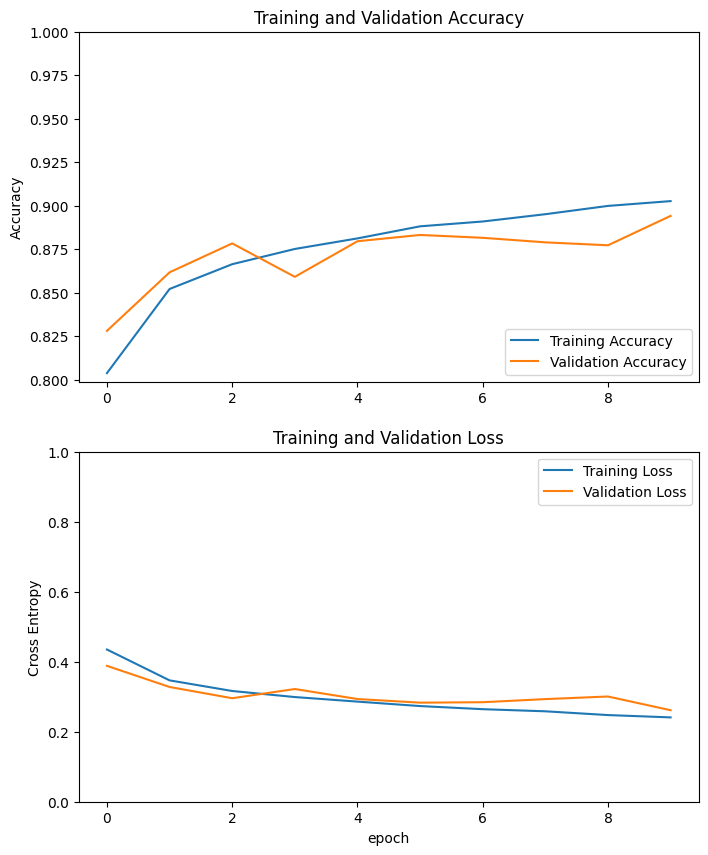

In [45]:
learning_curve(history)


In [46]:
# Layers
config_2 = [Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3), kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Flatten(),
            # Fully connected layer with Dropout
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')]

model_2 = Sequential(config_2)

# Compile
learning_rate = 0.001
opt = keras.optimizers.Adam(learning_rate = learning_rate)
model_2.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Summary
model_2.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,488,513 (9.49 MB)

 Trainable params: 2,487,553 (9.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [47]:
# Model fitting
history_2 = model_2.fit(train_generator,
                        epochs = 6,
                        validation_data = val_generator)
history_2

Epoch 1/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1138s 207ms/step - accuracy: 0.8139 - loss: 0.4894 - val_accuracy: 0.8745 - val_loss: 0.3155
Epoch 2/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1261s 229ms/step - accuracy: 0.8882 - loss: 0.2858 - val_accuracy: 0.8865 - val_loss: 0.2883
Epoch 3/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 13000s 2s/step - accuracy: 0.9062 - loss: 0.2467 - val_accuracy: 0.8010 - val_loss: 0.7403
Epoch 4/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1291s 235ms/step - accuracy: 0.9171 - loss: 0.2205 - val_accuracy: 0.7717 - val_loss: 0.8628
Epoch 5/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1314s 239ms/step - accuracy: 0.9243 - loss: 0.2027 - val_accuracy: 0.8688 - val_loss: 0.3359
Epoch 6/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1219s 222ms/step - accuracy: 0.9302 - loss: 0.1881 - val_accuracy: 0.7523 - val_loss: 1.2822


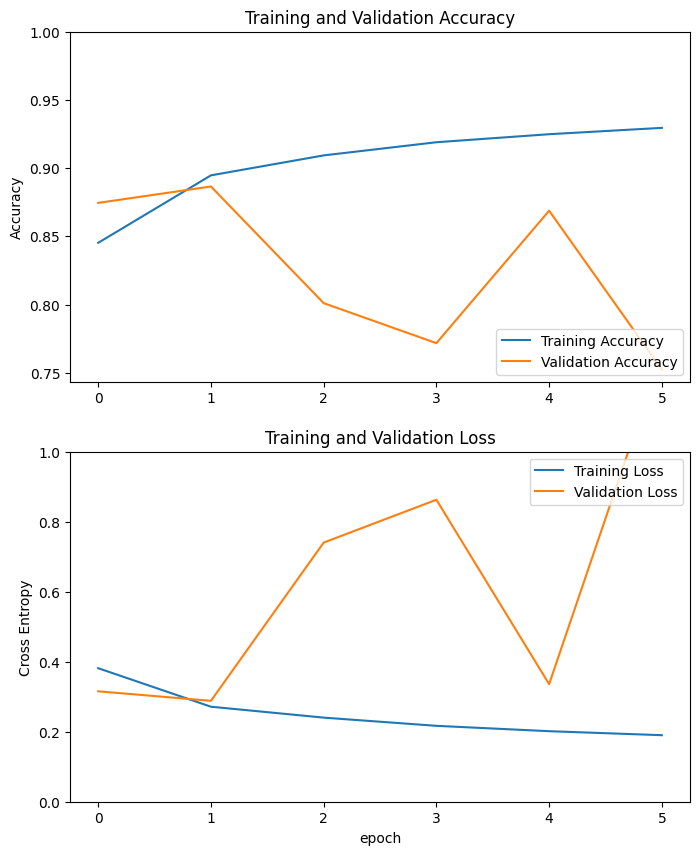

In [48]:
learning_curve(history_2)

#### Model 3: Lower Learning Rate, More Epochs

Why: A lower learning rate (0.0001) prevents unstable updates and improves convergence.

How: Increase the number of epochs to allow the model more time to learn with smaller updates.

Goal: Achieve smoother, more stable training and better generalization.


In [49]:
# Define model architecture
config_3 = [
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3), kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate=0.5),
    Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
]

model_3 = Sequential(layers=config_3)

# Compile the model
learning_rate = 0.0001  # Lower learning rate for smoother convergence
opt = keras.optimizers.Adam(learning_rate=learning_rate)
model_3.compile(optimizer=opt,
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Display model architecture
model_3.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,488,513 (9.49 MB)

 Trainable params: 2,487,553 (9.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [50]:
from keras.callbacks import EarlyStopping

# Set up early stopping to monitor validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model with early stopping
history_3 = model_3.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

history_3

Epoch 1/25
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1174s 213ms/step - accuracy: 0.7971 - loss: 0.4701 - val_accuracy: 0.8601 - val_loss: 0.3262
Epoch 2/25
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 40479s 7s/step - accuracy: 0.8567 - loss: 0.3388 - val_accuracy: 0.8805 - val_loss: 0.2907
Epoch 3/25
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1222s 222ms/step - accuracy: 0.8808 - loss: 0.2879 - val_accuracy: 0.8897 - val_loss: 0.2715
Epoch 4/25
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1192s 217ms/step - accuracy: 0.8941 - loss: 0.2591 - val_accuracy: 0.9070 - val_loss: 0.2424
Epoch 5/25
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 4441s 807ms/step - accuracy: 0.9049 - loss: 0.2389 - val_accuracy: 0.9146 - val_loss: 0.2203
Epoch 6/25
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1426s 259ms/step - accuracy: 0.9111 - loss: 0.2248 - val_accuracy: 0.9221 - val_loss: 0.2055
Epoch 7/25
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 6918s 1s/step - accuracy: 0.9164 - loss: 0.2128 - val_accuracy: 0.9213 - val_loss: 0.2018
Epoch 8/25
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1088s 198ms/step -

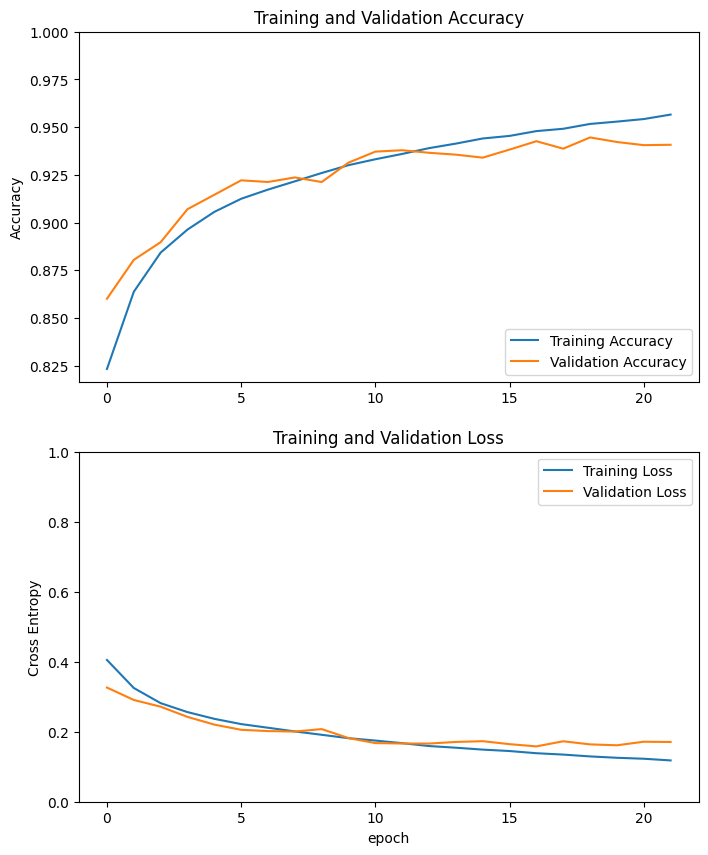

In [52]:
learning_curve(history_3)

#### Conclusion and Submission

I compared three models: a basic two-layer CNN, a deeper four-layer CNN with Batch Normalization and Dropout, and a third that modified Model 2 by reducing the learning rate and increasing epochs.

Model 3 achieved the best validation score with smoother cross-entropy loss. Lowering the learning rate to 0.0001 improved performance, though training took significantly longer even on GPU.

However, Model 3 showed signs of overfitting, with a noticeable gap between validation and test accuracy. Using more diverse augmentations with `ImageDataGenerator` could help improve generalization.
